In [3]:
# Install missing packages
%pip install imbalanced-learn ucimlrepo

# Imports
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [4]:
wine_quality = fetch_ucirepo(id=186)

X = wine_quality.data.features
y = wine_quality.data.targets

print("Loading dataset...")

Loading dataset...


In [5]:
scaler = StandardScaler()

# Fit the scaler to the data and transform it
# We wrap it in pd.DataFrame to keep the column names (important for plotting later!)
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [6]:
print("Normalization Complete.\n")

# Check 'Total Sulfur Dioxide' before and after
print(f"Mean of Sulfur Dioxide (Before): {X['total_sulfur_dioxide'].mean():.2f}")
print(f"Mean of Sulfur Dioxide (After):  {X_normalized['total_sulfur_dioxide'].mean():.2f} (Should be close to 0)")

print("\nFirst 5 rows of Normalized Data:")
print(X_normalized.head())

Normalization Complete.

Mean of Sulfur Dioxide (Before): 115.74
Mean of Sulfur Dioxide (After):  -0.00 (Should be close to 0)

First 5 rows of Normalized Data:
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       3.073817         -0.362438     1.661085       -0.744778   0.541412   
4       0.142473          2.188833    -2.192833       -0.744778   0.569958   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.100140             -1.446359  1.034993  1.813090   0.193097   
1            -0.311320             -0.862469  0.701486 -0.115073   0.999579   
2            -0.874763             -1.092486  0.768188  0.258120   0.797958   
3            -0.762074             -0.986324  1.101694

In [7]:
# We keep 20% of data hidden for testing (X_test, y_test)
# We use X_normalized from the previous step
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Split Successfully.")
print(f"Training Set Size: {X_train.shape} samples")
print(f"Test Set Size: {X_test.shape[0]} samples")

Data Split Successfully.
Training Set Size: (5197, 11) samples
Test Set Size: 1300 samples


In [8]:
# STEP 2: Apply SMOTE (Balancing)
# ---------------------------------------------------------
print("\nApplying SMOTE to Training Data...")

# Initialize SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)

# Resample ONLY the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the counts of each quality score
print("\n--- Class Distribution Before SMOTE ---")
print(y_train.value_counts().sort_index())

print("\n--- Class Distribution After SMOTE ---")
print(y_train_balanced.value_counts().sort_index())


Applying SMOTE to Training Data...

--- Class Distribution Before SMOTE ---
quality
3            24
4           173
5          1710
6          2269
7           863
8           154
9             4
Name: count, dtype: int64

--- Class Distribution After SMOTE ---
quality
3          2269
4          2269
5          2269
6          2269
7          2269
8          2269
9          2269
Name: count, dtype: int64


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

# ---------------------------------------------------------
# STEP 1: Define the Model and Parameters
# ---------------------------------------------------------
rf = RandomForestClassifier(random_state=42)

# The "Grid" of settings we want to test
# n_estimators = Number of trees in the forest
# max_depth = How deep each tree can grow (prevents overfitting)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# ---------------------------------------------------------
# STEP 2: Run Grid Search (The "Tuning")
# ---------------------------------------------------------
print("Starting Grid Search...")
start_time = time.time()

# cv=3 means it cross-validates 3 times for every combination
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Train on the BALANCED data
grid_search.fit(X_train_balanced, y_train_balanced)

end_time = time.time()
print(f"Training Complete! Time taken: {end_time - start_time:.2f} seconds")

# ---------------------------------------------------------
# STEP 3: View Results
# ---------------------------------------------------------
print("\n--- Best Parameters Found ---")
print(grid_search.best_params_)

# Save the best model to a variable for the next step
best_rf_model = grid_search.best_estimator_

Starting Grid Search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Complete! Time taken: 205.21 seconds

--- Best Parameters Found ---
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


/tmp/ipython-input-3197707541.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Chemical', data=feature_df, palette='viridis')


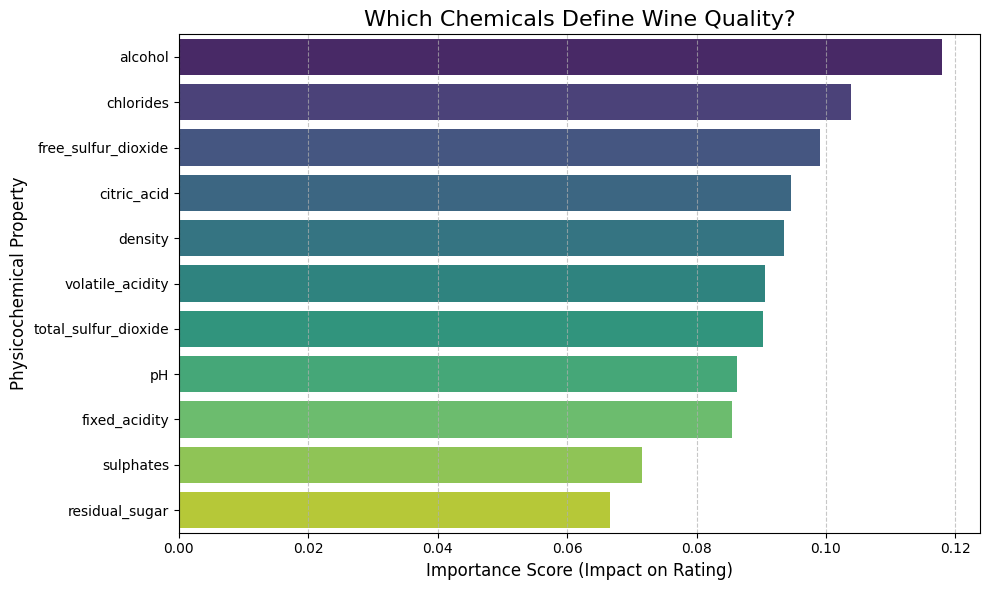

Top 3 Predictors of Quality:
               Chemical  Importance
10              alcohol    0.117914
4             chlorides    0.103893
5   free_sulfur_dioxide    0.099126


In [10]:
%pip install matplotlib
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------------------------------------
# STEP 4: Extract Feature Importance
# ---------------------------------------------------------
# Get the "Feature Importance" scores from the best model
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Create a sorted DataFrame for plotting
feature_df = pd.DataFrame({'Chemical': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# ---------------------------------------------------------
# STEP 5: Visualize (The Project Outcome)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Chemical', data=feature_df, palette='viridis')

plt.title("Which Chemicals Define Wine Quality?", fontsize=16)
plt.xlabel("Importance Score (Impact on Rating)", fontsize=12)
plt.ylabel("Physicochemical Property", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# STEP 6: Interpretation
# ---------------------------------------------------------
print("Top 3 Predictors of Quality:")
print(feature_df.head(3))

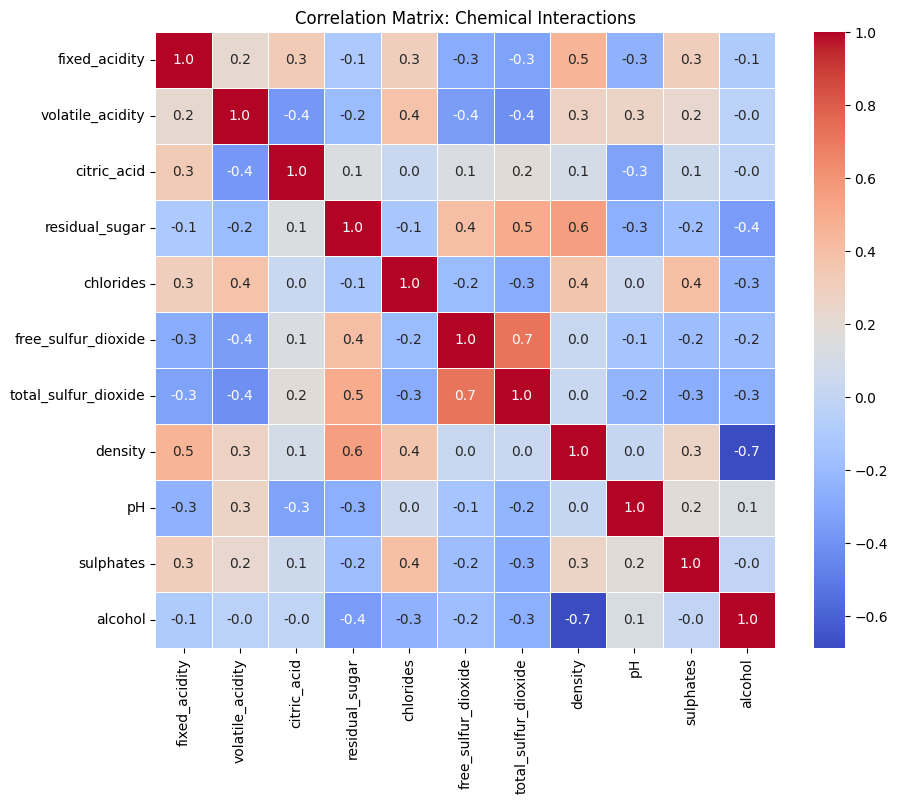

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
plt.figure(figsize=(10, 8))
correlation = X.corr()

# Plot heatmap
sns.heatmap(correlation, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix: Chemical Interactions")
plt.show()